# As votações no tempo: comparação das legislaturas e anos

:::{margin}
```{image} ./_images/Book_of_Los_title.jpg
:alt: Book of Los
:width: 200px
:align: center
```
:::

```{epigraph}
A verdade tem limites. O erro nenhum: a cair, a cair: \
Anos e anos, e eras e eras \
Continuou a cair pelo vazio, e sempre mais vazio \
Para continuar a cair dia & noite sem fim.

-- William Blake , «O Livro de Los»
```

In [1]:
import pandas as pd
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from IPython.core.display import display, HTML
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from datetime import timedelta
#sns.set(font="EB Garamond")
sns.set_theme(style="whitegrid", palette="pastel")
%matplotlib inline

In [2]:
## Get the data
from urllib.request import urlopen
import xml.etree.ElementTree as ET

#l13_ini_url = 'https://app.parlamento.pt/webutils/docs/doc.xml?path=6148523063446f764c324679626d56304c3239775a57356b595852684c3052685a47397a51574a6c636e52766379394a626d6c6a6157463061585a686379395953556c4a4a5449775447566e61584e7359585231636d45765357357059326c6864476c3259584e5953556c4a4c6e687462413d3d&fich=IniciativasXIII.xml&Inline=true'
#l13_ini_tree = ET.parse(urlopen(l13_ini_url))
l13_ini_file = '../l13_ini.xml'
l13_ini_tree = ET.parse(l13_ini_file)
l14_ini_file = '../l14_ini.xml'
l14_ini_tree = ET.parse(l14_ini_file)


In [3]:
from bs4 import BeautifulSoup
import re
import pandas as pd

## Iteract through the existing dict
def party_from_votes (votes):
    """
    Determines the position of a party based on the majority position by summing all the individual votes.
    Argument is a dictionary returned by parse_voting()
    Returns a dictionary with the majority position of each party
    """
    party_vote = {}
    for k, v in votes.items():
        ## Erase the name of the MP and keep the party only
        ## only when it's not from the "Ninsc" group - 
        ## these need to be differentiated by name
        if re.match(".*\(Ninsc\)" , k) is None:
            nk = re.sub(r".*\((.+?)\).*", r"\1", k)
        else:
            nk = k
        ## If it's the first entry for a key, create it
        if nk not in party_vote:
            party_vote[nk] = [0,0,0]
        ## Add to a specific index in a list
        if v == "A Favor":
            party_vote[nk][0] += 1
        elif v == "Abstenção":
            party_vote[nk][1] += 1
        elif v == "Contra":
            party_vote[nk][2] += 1
    for k,v in party_vote.items():
        party_vote[k]=["A Favor", "Abstenção", "Contra"][v.index(max(v))]
    return party_vote

def parse_voting(v_str):
    """Parses the voting details in a string and returns a dict.
    
    Keyword arguments:
    
    v_str: a string with the description of the voting behaviour.
    """
    ## Split by the HTML line break and put it in a dict
    d = dict(x.split(':') for x in v_str.split('<BR>'))
    ## Remove the HTML tags
    for k, v in d.items():
        ctext = BeautifulSoup(v, "lxml")
        d[k] = ctext.get_text().strip().split(",")
    ## Invert the dict to get a 1-to-1 mapping
    ## and trim it
    votes = {}
    if len(v_str) < 1000:    # Naive approach but realistically speaking... works well enough.
        for k, v in d.items():
            for p in v:
                if (p != ' ' and                                       # Bypass empty entries
                    re.match("[0-9]+", p.strip()) is None and           # Bypass quantified divergent voting patterns
                    (re.match(".*\w +\(.+\)", p.strip()) is None or     # Bypass individual votes...
                     re.match(".*\(Ninsc\)" , p.strip()) is not None)): # ... except when coming from "Ninsc"
                        #print("|"+ p.strip() + "|" + ":\t" + k)
                        votes[p.strip()] = k
    else:  # This is a nominal vote since the size of the string is greater than 1000
        for k, v in d.items():
            for p in v:
                if p != ' ':
                    votes[p.strip()] = k
        ## Call the auxiliary function to produce the party position based on the majority votes
        votes = party_from_votes(votes)
    return votes

In [4]:
import collections

def ini_to_df(root):
    counter=0

    ## We will build a dataframe from a list of dicts
    ## Inspired by the approach of Chris Moffitt here https://pbpython.com/pandas-list-dict.html
    init_list = []

    for voting in root.findall(".//pt_gov_ar_objectos_VotacaoOut"):
        votep = voting.find('./detalhe')
        if votep is not None:
            init_dict = collections.OrderedDict()
            counter +=1                 
            init_dict['id'] = voting.find('id').text
            ## Add the "I" for Type to mark this as coming from "Iniciativas"
            init_dict['Tipo'] = "I"
            for c in voting:
                if c.tag == "detalhe":
                    for party, vote in parse_voting(c.text).items():
                        init_dict[party] = vote 
                elif c.tag == "descricao":
                        init_dict[c.tag] = c.text
                elif c.tag == "ausencias":
                        init_dict[c.tag] = c.find("string").text
                else:
                        init_dict[c.tag] = c.text
            init_list.append(init_dict)
        ## Provide progression feedback
        #print('.', end='')
    return pd.DataFrame(init_list)
        
#print(counter)

In [5]:
def ini_to_df_ini(root):
    counter=0

    ## We will build a dataframe from a list of dicts
    ## Inspired by the approach of Chris Moffitt here https://pbpython.com/pandas-list-dict.html
    init_list = []

    for ini in root.findall("pt_gov_ar_objectos_iniciativas_DetalhePesquisaIniciativasOut"):
        init_dict = collections.OrderedDict()
        counter +=1
        for c in ini:
            if c.tag == "iniAutorGruposParlamentares":
                if c.find('pt_gov_ar_objectos_AutoresGruposParlamentaresOut/GP') is not None:
                    init_dict[c.tag] = c.find('pt_gov_ar_objectos_AutoresGruposParlamentaresOut/GP').text
            else:
                init_dict[c.tag] = c.text
        init_list.append(init_dict)

        ## Provide progression feedback
        #print('.', end='')
    return pd.DataFrame(init_list)
        
#print(counter)

In [6]:
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from itables import show
from scipy.cluster.hierarchy import dendrogram

def political_distance_matrix(vdf,plist):
    vdf = vdf[plist]
    vdf = vdf.replace(["A Favor", "Contra", "Abstenção", "Ausência"], [1,-1,0,0]).fillna(0)
    ## Transpose the dataframe used for the heatmap
    vdf_votes_t = vdf.transpose()

    ## Determine the Eucledian pairwise distance
    ## ("euclidean" is actually the default option)
    pwdist = pdist(vdf_votes_t, metric='euclidean')

    ## Create a square dataframe with the pairwise distances: the distance matrix
    distmat = pd.DataFrame(
        squareform(pwdist), # pass a symmetric distance matrix
        columns = vdf_votes_t.index,
        index = vdf_votes_t.index
    )
    return distmat
    #return ((distmat-distmat.min().min())/(distmat.max().max()-distmat.min().min()))*1

def political_pwdist(vdf,plist):
    vdf = vdf[plist]
    vdf = vdf.replace(["A Favor", "Contra", "Abstenção", "Ausência"], [1,-1,0,0]).fillna(0)
    ## Transpose the dataframe used for the heatmap
    vdf_votes_t = vdf.transpose()

    ## Determine the Eucledian pairwise distance
    ## ("euclidean" is actually the default option)
    pwdist = pdist(vdf_votes_t, metric='euclidean')
    return pwdist
    #return ((distmat-distmat.min().min())/(distmat.max().max()-distmat.min().min()))*1
    
def political_distance_clustermap(vdf, plist, subtitle, size, pal):
    vdf = vdf[plist]
    vdf = vdf.replace(["A Favor", "Contra", "Abstenção", "Ausência"], [1,-1,0,0]).fillna(0)
    ## Perform hierarchical linkage on the distance matrix using Ward's method.
    distmat= political_distance_matrix(vdf,plist)
    pwdist = political_pwdist(vdf,plist)
    distmat_link = hc.linkage(pwdist, method="ward", optimal_ordering=True )
    fig = sns.clustermap(
        distmat,
        annot = True,
        cmap=sns.color_palette(pal),
        linewidth=1,
        #standard_scale=1,
        row_linkage=distmat_link,
        col_linkage=distmat_link,
        #fmt=".0%",
        figsize=size,
        
    ).fig.suptitle(subtitle,y=1)
    return fig
    #plt.show()

def political_linkage(vdf,plist):
    vdf = vdf[plist]
    distmat= political_distance_matrix(vdf,plist)
    pwdist = political_pwdist(vdf,plist)
    distmat_link = hc.linkage(pwdist, method="ward", optimal_ordering=True)
    return distmat_link

def political_dendogram(vdf, plist, subtitle):
    vdf = vdf[plist]

    fig = plt.figure(figsize=(8,5))
    dendrogram(political_linkage(vdf,plist), labels=vdf.columns)
    plt.title(subtitle)
    plt.show()
    
def political_heatmap(vdf,plist,title):
    vdf_hmn = vdf[plist].replace(["A Favor", "Contra", "Abstenção", "Ausência"], [1,-1,0,2]).fillna(0)
    voting_palette = ["#FB6962","#FCFC99","#79DE79"]
    fig = plt.figure(figsize=(8,8))
    sns.heatmap(vdf_hmn,
                square=False,
                yticklabels = False,
                cbar=False,
                cmap=sns.color_palette(voting_palette),
               )
    plt.title(title)
    plt.show()

In [7]:
l13_parties = ['BE', 'PCP' ,'PEV', 'PS', 'PAN', 'PSD','CDS-PP']
l14_parties = ['BE', 'PCP', 'PEV', 'L/JKM', 'PS', 'PAN','PAN/CR','PSD','IL','CDS-PP', 'CH']


In [8]:
l13_ini_df = ini_to_df(l13_ini_tree)
l14_ini_df = ini_to_df(l14_ini_tree)

In [9]:
## Copy Livre voting record to new aggregate columns...
l14_ini_df["L/JKM"] = l14_ini_df["L"]
## ... and fill the NAs with JKM voting record.
l14_ini_df["L/JKM"] = l14_ini_df["L/JKM"].fillna(l14_ini_df["Joacine Katar Moreira (Ninsc)"])
l14_ini_df[["descricao","L","Joacine Katar Moreira (Ninsc)","L/JKM"]]
## Copy PAN voting record to new aggregate columns...
l14_ini_df["PAN/CR"] = l14_ini_df["PAN"]
## ... and update/replace with CR voting where it exists
l14_ini_df["PAN/CR"].update(l14_ini_df["Cristina Rodrigues (Ninsc)"])
l14_ini_df[["descricao","PAN","Cristina Rodrigues (Ninsc)","PAN/CR"]]

l14_votes = l14_ini_df
l14_votes['data']= pd.to_datetime(l14_votes['data'])
l14_votes['ano'] = pd.DatetimeIndex(l14_votes['data']).year
l14_votes['leg'] = 14
l14_votes_hm=l14_votes[l14_parties]
l14_votes_nu = l14_votes[l14_votes["unanime"] != "unanime"]
l14_votes_nu_hm=l14_votes_nu[l14_parties]
l14_min_date=min(l14_votes["data"])


In [10]:
l13_votes = l13_ini_df
l13_votes['data']= pd.to_datetime(l13_votes['data'])
l13_votes['ano'] = pd.DatetimeIndex(l13_votes['data']).year
l13_votes['leg'] = 13
l13_min_date=min(l13_votes["data"])
l13_max_date=l14_min_date - timedelta(1)
l13_votes = l13_votes[(l13_votes['data'] <= l13_max_date)]
l13_votes_hm=l13_votes[l13_parties]
l13_votes_nu = l13_votes[l13_votes["unanime"] != "unanime"]
l13_votes_nu_hm=l13_votes_nu[l13_parties]


## A XIII Legislatura, ano a ano

Olhando para os anos da XIII Legislatura, como se comparam os vários anos com o resultado final? Recordemos o resultado final do `clustermap` para toda a legislatura, e comparemos com a análise obtida pela consideração apenas das votações de cada ano, isoladamente:

```{margin} XIII Legislatura
```

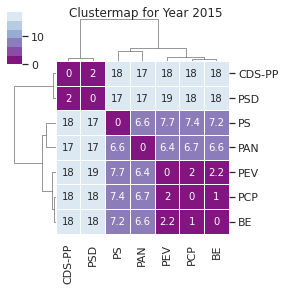

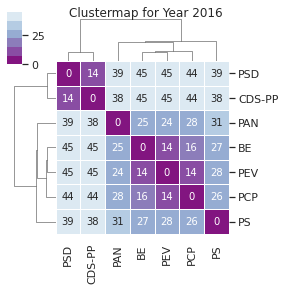

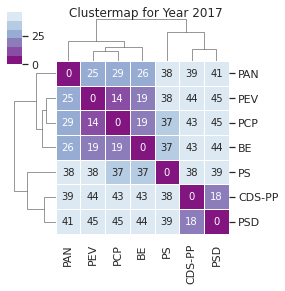

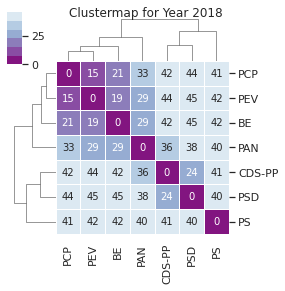

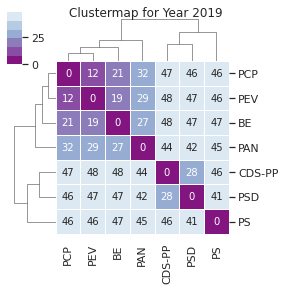

In [11]:
for year in sorted(set(l13_votes["ano"])):
    y_votes=l13_votes[(l13_votes['data'] > '{}-01-01'.format(year)) & (l13_votes['data'] < '{}-01-01'.format(year+1))]
    y_votes = y_votes[l13_parties]
    y_votes = y_votes.replace(["A Favor", "Contra", "Abstenção", "Ausência"], [1,-1,0,0]).fillna(0)
    political_distance_clustermap(y_votes, l13_parties,"Clustermap for Year {}".format(year),(4,4), "BuPu_r")
plt.show()



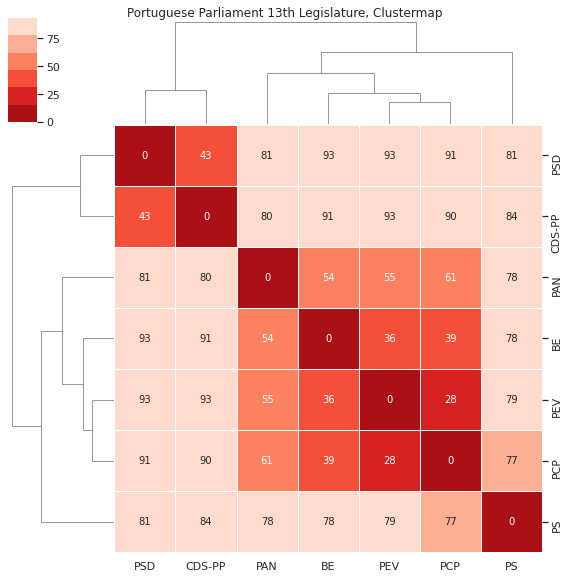

In [12]:
## Change the mapping, we now consider Abst and Aus the same
l13_votes_hmn = l13_votes_hm.replace(["A Favor", "Contra", "Abstenção", "Ausência"], [1,-1,0,0]).fillna(0)

## Transpose the dataframe used for the heatmap
l13_votes_t = l13_votes_hmn.transpose()

## Determine the Eucledian pairwise distance
## ("euclidean" is actually the default option)
l13_pwdist = pdist(l13_votes_t, metric='euclidean')

## Create a square dataframe with the pairwise distances: the distance matrix
l13_distmat = pd.DataFrame(
    squareform(l13_pwdist), # pass a symmetric distance matrix
    columns = l13_votes_t.index,
    index = l13_votes_t.index
)
#show(distmat, scrollY="200px", scrollCollapse=True, paging=False)

## Normalise by scaling between 0-1, using dataframe max value to keep the symmetry.
## This is essentially a cosmetic step
#distmat=((distmat-distmat.min().min())/(distmat.max().max()-distmat.min().min()))*1
#distmat.style.apply(highlight_diag, axis=None)
## Perform hierarchical linkage on the distance matrix using Ward's method.
l13_distmat_link = hc.linkage(l13_pwdist, method="ward", optimal_ordering=True )

sns.clustermap(
    l13_distmat,
    annot = True,
    cmap=sns.color_palette("Reds_r"),
    linewidth=1,
    #standard_scale=1,
    row_linkage=l13_distmat_link,
    col_linkage=l13_distmat_link,
    figsize=(8,8)).fig.suptitle('Portuguese Parliament 13th Legislature, Clustermap',y=1)
plt.show()

### A evolução da XIII legislatura

Considerando os anos individualmente (isto é, **apenas as votações de determinado ano, sem considerar os anos anteriores**, observam-se três fases distintas caracterizadas mais pelo posicionamento do PS do que mudanças nos restantes agrupamentos:

* **2015-2016**. O PS tem, nestes anos, sempre maior proximidade com os partidos à sua esquerda, sendo 2015 particularmente vincando; se em 2016 se podem observar alterações nas distâncias (visíveis, de resto, no atenuar das cores utilizadas), é ainda clara a "fronteira" exterior composta por PS e PAN, ambos mais próximos de PCP, PEV e BE que de PSD e CDS-PP.
* **2017**. O PS aparece agora agrupado com CDS-PP e PSD, mas note-se a forma como o algoritmo de agrupamento funciona: o PS está praticamente equidistante de todos, e na verdade ligeiramente mais próximo de BE e PCP do que de PS e CDS-PP; acontece que os partidos à esquerda do PS estão significativamente mais distantes desses partidos, levando a que a primeira divisão feita os coloque separados do PS.
* **2018-2019**: Aqui o PS, pela primeira vez, tem maior distância de alguns dos partidos à sua esquerda do que tem do PSD. Note-se que as diferenças são ainda bastante pequenas, embora aumentem em 2019.

Em resumo, parece existir uma tendência para a deslocação do centro de gravidade com o passar dos anos, que não altera o resultado final.

## A XIV Legislatura, ano a ano

A mesma análise para a XIV legislatura:


```{margin} XIV Legislatura
```

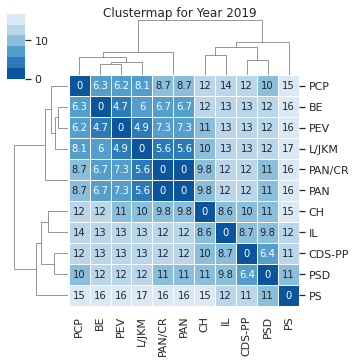

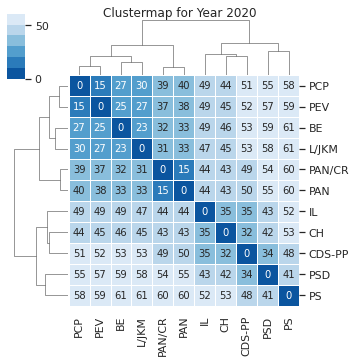

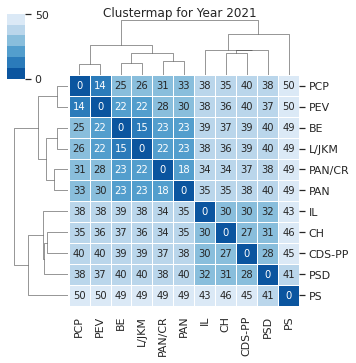

In [13]:
for year in sorted(set(l14_votes["ano"])):
    y_votes=l14_votes[(l14_votes['data'] > '{}-01-01'.format(year)) & (l14_votes['data'] < '{}-01-01'.format(year+1))]
    y_votes = y_votes[l14_parties]
    y_votes = y_votes.replace(["A Favor", "Contra", "Abstenção", "Ausência"], [1,-1,0,0]).fillna(0)
    political_distance_clustermap(y_votes, l14_parties,"Clustermap for Year {}".format(year),(5,5), "Blues_r")
plt.show()


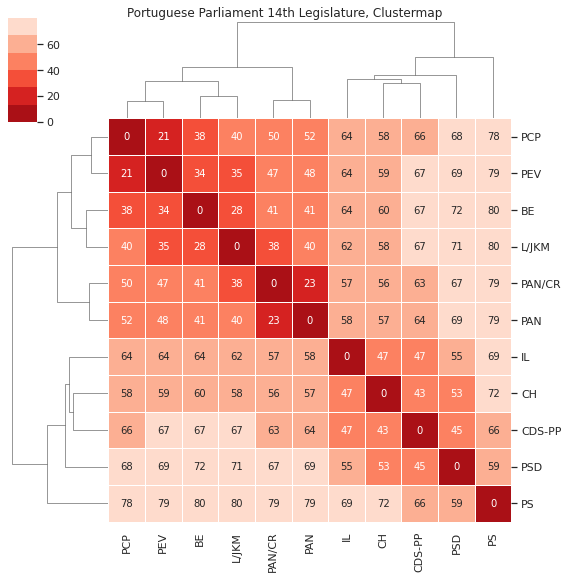

In [14]:
## Change the mapping, we now consider Abst and Aus the same
l14_votes_hmn = l14_votes_hm.replace(["A Favor", "Contra", "Abstenção", "Ausência"], [1,-1,0,0]).fillna(0)

## Transpose the dataframe used for the heatmap
l14_votes_t = l14_votes_hmn.transpose()

## Determine the Eucledian pairwise distance
## ("euclidean" is actually the default option)
l14_pwdist = pdist(l14_votes_t, metric='euclidean')

## Create a square dataframe with the pairwise distances: the distance matrix
l14_distmat = pd.DataFrame(
    squareform(l14_pwdist), # pass a symmetric distance matrix
    columns = l14_votes_t.index,
    index = l14_votes_t.index
)
#show(distmat, scrollY="200px", scrollCollapse=True, paging=False)

## Normalise by scaling between 0-1, using dataframe max value to keep the symmetry.
## This is essentially a cosmetic step
#distmat=((distmat-distmat.min().min())/(distmat.max().max()-distmat.min().min()))*1
#distmat.style.apply(highlight_diag, axis=None)
## Perform hierarchical linkage on the distance matrix using Ward's method.
l14_distmat_link = hc.linkage(l14_pwdist, method="ward", optimal_ordering=True )

sns.clustermap(
    l14_distmat,
    annot = True,
    cmap=sns.color_palette("Reds_r"),
    linewidth=1,
    #standard_scale=1,
    row_linkage=l14_distmat_link,
    col_linkage=l14_distmat_link,
    figsize=(8,8)).fig.suptitle('Portuguese Parliament 14th Legislature, Clustermap',y=1)
plt.show()

### A evolução da XIV Legislatura

Ao contrário da legislatura anterior, esta tem nos outros partidos (que não o PS) a maior parte das diferenças:

* **2019**. A primeira vez que os novos partidos aparecem, e o seu primeiro agrupamento: é o único ano onde a IL aparece agrupada com o CH, eo CDS-PP com o PSD. Á esquerda, a curiosidade do PEV agrupar com BE (e não com o PCP, como em todos os outros anos): de um lado e de outro convém notar que o ano de 2019 tem menos votações por começar já no segundo semestre, o que leva a que os resultados sejam mais susceptíveis de variação. O PS segue a tendência que se observa do último ano da legislatura anterior, com menor distância dos partidos à sua direita mas numa situação de alguma centralidade.
* **2020**: Cristina Rodrigues já com votações próprias, agrupada com o PAN (até porque as votações até à data da sua saída são consideradas as mesmas). À esquerda o cenário que será final, e à direita também, com a excepção do agrupamento de PS e PSD.
* **2021**: PS a separar-se do PSD e, em geral, reduzindo as distâncias dos partidos à sua esquerda comparando com o ano anterior. Se até 2021 a tendência foi a de aumento da distância do PS dos partidos à sua esquerda (de forma geral, e com dimensões diferentes), neste ano essa distância estabiliza ou reduz-se ligeiramente.